# Neural Network for Clustering PI-ICR Ellipses

Author: Scott Campbell

This notebook trains a neural network for clustering data that is similar to what PI-ICR data may look like.

In [3]:
# import the necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.filters import gaussian_filter

C:\Users\campbels\AppData\Local\Temp\ipykernel_33096\1122294280.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Create a Dataset of Simulated Data

In [4]:
nx = 50
mcp_radius = 50

x_list = np.linspace(-mcp_radius, mcp_radius, nx)
mesh_X, mesh_Y = np.meshgrid(x_list, x_list)
dx = x_list[1] - x_list[0]

def __get_data_for_NN__(shot_x, shot_y, normalize=True):
    """ This method take a list of shots, discretizes to the domain, and normalizes so that the grid sums to one
    Args: 
        shot_x (list): list of x coords of each shot. Shots outside MCP radius are ignored
        shot_y (list): list of y coords of each shot. Shots outside MCP radius are ignored
    Returns:
        a 1D list (row-wise) corresponding to the normalized MCP hits
    """
    Z = np.zeros(mesh_X.shape) # Create a blank array to store shot info
    for kk in range(len(shot_x)):
        if np.sqrt(shot_x[kk]**2 + shot_y[kk]**2) < mcp_radius:
            x_idx, y_idx = int((shot_x[kk] + mcp_radius)/dx), int((shot_y[kk] + mcp_radius)/dx)
            Z[y_idx][x_idx] += 1
    if normalize: 
        Z = Z / np.sum(Z) # Normalize so that Z sums to 1
    return Z.reshape((nx**2))

In [5]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def generate_ellipse_data(num_sim_samples):
    mcp_radius = 15 # radius of MCP in ns

    max_ellipse_offset = 0.15*mcp_radius # allow the ellipse to be offset by up to X% mcp radius
    max_ellipse_ab_diff = 0.25 # the ellipse params can't be more than this percent diff
    min_percent_noise = 0.25 # min amount of noise relative to the cluster data
    max_percent_noise = 1.25 # max amount of noise relative to the cluster data
    min_ellipse_rho_sigma = 0.01*mcp_radius # we add normal noise to the radii of ellipse. This is min std dev
    max_ellipse_rho_sigma = 0.06*mcp_radius # we add normal noise to the radii of ellipse. This is max std dev
    min_num_ellipse_data = 80
    max_num_ellipse_data = 200 # up to this many shots in a cluster

    start_time = time.time()
    all_input = []
    all_output = []
    for _ in range(num_sim_samples):
        n_ellipse_points = np.random.randint(min_num_ellipse_data, high=max_num_ellipse_data)
        # define an offset
        off_x, off_y = np.random.uniform(low=0, high=max_ellipse_offset), np.random.uniform(low=0, high=max_ellipse_offset)
        # define the elipse major/minor axes
        max_ellipse_ab = mcp_radius - np.sqrt(off_x**2 + off_y**2)
        ellipse_a = np.random.uniform(low=0.5*max_ellipse_ab, high=max_ellipse_ab)
        ellipse_b = np.random.uniform(low=(1-max_ellipse_ab_diff)*ellipse_a, high=ellipse_a) 
        # Create points on the ellipse
        if np.random.uniform(low=0,high=1) < 0.5: # 50% of the time, do a full ellipse
            ellipse_phi = np.random.uniform(low=0, high=2*np.pi, size=n_ellipse_points)
            ellipse_rho = np.sqrt(np.power(ellipse_a*np.cos(ellipse_phi),2) + np.power(ellipse_b*np.sin(ellipse_phi),2)) # calculate the radius of ellipse at angle phi
        else: # otherwise, choose a normal distribution
            phi_sigma = np.random.uniform(low=2, high=4) # normal distribution from pi/3 rad to pi rad
            center_angle = np.random.uniform(low=2, high=2*np.pi)
            ellipse_phi = center_angle + np.random.normal(loc=0, scale=phi_sigma, size=n_ellipse_points)
            ellipse_rho = np.sqrt(np.power(ellipse_a*np.cos(ellipse_phi),2) + np.power(ellipse_b*np.sin(ellipse_phi),2)) # calculate the radius of ellipse at angle phi

        # add some randomness to the radii
        rho_sigma = np.random.uniform(low=min_ellipse_rho_sigma, high=max_ellipse_rho_sigma)
        ellipse_rho += np.random.normal(loc=0, scale=rho_sigma, size=n_ellipse_points)

        # translate and rotate the ellipse in space
        ellipse_theta = np.random.uniform(low=0, high=2*np.pi) # define rotation angle of ellipse
        ellipse_phi += ellipse_theta
        ellipse_x, ellipse_y = pol2cart(ellipse_rho, ellipse_phi)
        ellipse_x, ellipse_y = ellipse_x + off_x, ellipse_y + off_y

        # Generate random noise
        n_noise = int(n_ellipse_points * np.random.uniform(low=min_percent_noise, high=max_percent_noise))
        noise_rho = np.random.uniform(low=0, high=mcp_radius, size=n_noise)
        noise_phi = np.random.uniform(low=0, high=2*np.pi, size=n_noise)
        noise_x, noise_y = pol2cart(noise_rho, noise_phi)

        # plt.figure()
        # plt.scatter(ellipse_x, ellipse_y)
        # plt.scatter(noise_x, noise_y)
        # plt.title("rotated and translated ellipse")
        # plt.show()

        # Finally, get the neural network input
        all_x, all_y = np.concatenate((ellipse_x,noise_x)), np.concatenate((ellipse_y,noise_y))
        input = DataObj.__get_data_for_NN__(all_x, all_y)
        output = DataObj.__get_data_for_NN__(ellipse_x, ellipse_y)

        # Scale up the input for faster training - each cell should be ~1
        input *= DataObj.nx**2
        output[output > 0] = 1

        all_input.append(input)
        all_output.append(output)

    print("Finished computing. Avg time per sample (s):", (time.time() - start_time)/num_sim_samples )
    return np.array(all_input), np.array(all_output)

# NOTE: X is rescaled such that the sum of every pixel equals nx^2
# NOTE: y is changed such that a pixel in the cluster has value 1, else 0
X_data, y_data = generate_ellipse_data(100000)
data_size = len(X_data[0])

# Split the data into training and validation (85:15)
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, train_size=0.85)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

NameError: name 'PIICR_Cluster_Object' is not defined

## Create the Neural Network

We are doing multi-label classification, where more then one feature can be 'true': a pixel is in the cluster

In [2]:
# Define some parameters for training the data
num_epochs = 10
batch_size = 64

# Create the neural network model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(data_size, kernel_initializer='he_uniform', activation="relu")) # Input layer
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(data_size, activation="sigmoid")) # Output layer

#optimizer = tf.keras.optimizers.SGD() # Adam optimizer far outperforms the SGD optimizer for this problem
optimizer = tf.keras.optimizers.Adam() # 1e-4 works pretty well to optimize the fastest. Maybe add schedule to decrease for later epochs?
model.compile(loss="binary_crossentropy", optimizer=optimizer,  metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

NameError: name 'data_size' is not defined

## Look at the Results for Test Data

Finished computing. Avg time per sample (s): 0.0018949270248413085


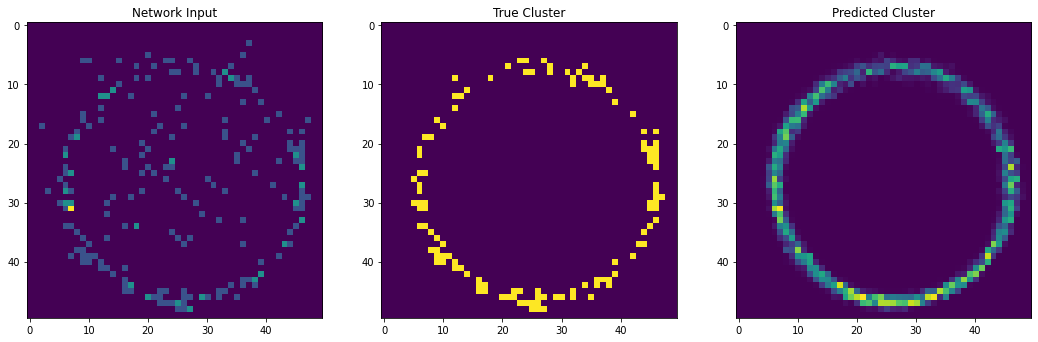

In [25]:
from matplotlib import cm

X_test, y_test = generate_ellipse_data(10)

# Get the predictions on the unknown testing set
y_pred = model.predict(X_test)

# Plot for random indices
index = np.random.randint(0, high=len(y_test))
curr_X_test, curr_y_test, curr_y_pred = X_test[index], y_test[index], y_pred[index]

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(curr_X_test.reshape((50,50)), cmap=cm.viridis)
plt.title("Network Input")
plt.subplot(1,3,2)
plt.title("True Cluster")
plt.imshow(curr_y_test.reshape((50,50)), cmap=cm.viridis)
plt.subplot(1,3,3)
plt.title("Predicted Cluster")
plt.imshow(curr_y_pred.reshape((50,50)), cmap=cm.viridis)

### Save the classifier for use later

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("PI-ICR_Ellipse_Cluster_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("PI-ICR_Ellipse_Cluster_Model.h5")